# Experiment 4

### Experiment Description

In this project, we will try to consider external parameters beyond the numerical ones, so **International News** will be taken and analyzed to see the impact they have on the S&P 500.

These analyses will try to extract different parameters that can be sent to the neural network, so it can take into account factors beyond just numbers. This will allow it to be trained not only with the historical behavior of the stock, but also with the human behavior seen in the news, considering political factors, economics, global crises, etc.

For this, we implemented the generation of 3 different parameters that the news will have, which are: the Volatility that the news causes in the S&P 500, the Relevance of the news to the S&P 500, and the Sentimental Analysis of the news. The purpose is to train the neural network with a broader view, not only based on the stock’s historical data.

#### Getting the Volatility that the news causes in the S&P 500

To get the volatility that a news item can cause in the S&P 500, the daily volatility of the stock (absolute price change between the current day and the previous day) was calculated and matched with the news from that day.

Then, a K-means algorithm was applied to determine if the volatility was low, medium, or high, and in this way, the news was assigned a volatility range.

#### Getting the Relevance of the News with the S&P 500

To get the relevance of the news to the S&P 500 stock, 620 news articles that were directly related to the S&P 500 were collected manually. From these, the 300 most important and repeated words were extracted.

Then, they were tokenized and a matrix was applied using the **TfidfVectorizer** library to calculate how many times and how often these words appeared in each news item.

Finally, the total sum of all these was taken, and a weight was assigned to show how related the news was to the S&P 500, narmalized from 0 - 10

#### Sentimental Analysis of the News

The **vaderSentiment** library was used to apply the **SentimenIntensityAnalyzer** function, which evaluates if the sentiment of the text is positive or negative, giving -1 as very negative, 0 as neutral, and 1 as positive.

#### Result of Generate News Parameters

![Experiment 4_News_Analysis](IMG/News_Analysis.png)



Finally, all the news from the day is collected, the average of each one of the values is calculated, and the final value that will be sent to the neural network is obtained.


# NLP Process

### Install necesary libraries

In [2]:
import sys
!{sys.executable} -m pip install vaderSentiment

You should consider upgrading via the '/Users/rodrigoesparza/.pyenv/versions/py_7_thesis/bin/python -m pip install --upgrade pip' command.


### Get All Preprocessed International News

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
df_news = pd.read_csv('../Data/Preprocessed/clean-nyt-news.csv')
df_news = df_news.drop(['Unnamed: 0'], axis=1)
df_news = df_news.drop(['Unnamed: 0.1'], axis=1)

In [6]:
df_news.head(2)

,date,all_text,clean_text
0,2000-01-01,"Playoffs or No, Dallas Provides The Motivation Waiting in the visiting locker room at Texas Stadium late tomorrow afternoon, the Giants will know whether the Green Bay Packers, who play earlier against Arizona, have won or are comfortably ahead. Article on upcoming New York Giants-Dallas Cowboys game; photo (M)",playoff dallas provide motivation wait visit locker room texas stadium late tomorrow afternoon giant know green bay packer play early arizona win comfortably ahead article upcoming new york giants dallas cowboys game photo m
1,2000-01-01,"On This First Day, a Fanfare for the New Era; Knowing the World To the Editor: Jeanne C Pond letter expresses hope that spiritual development, artistic knowledge and skills and self-esteem flourish in new century; drawing",day fanfare new era know world editor jeanne c pond letter express hope spiritual development artistic knowledge skill self esteem flourish new century drawing


In [7]:
df_news.shape

(2189674, 3)

In [8]:
df_news['date'] = pd.to_datetime(df_news['date'], format='%Y-%m-%d')

In [9]:
print("Oldst Date: ", df_news['date'].min())
print("Recent Date: ", df_news['date'].max())

Oldst Date:  2000-01-01 00:00:00
Recent Date:  2024-12-14 00:00:00


### Get SPY Stock market dataset

In [10]:
SPY_stocks = pd.read_csv("../data/Preprocessed/SPY_Data.csv")
SPY_stocks = SPY_stocks.drop(['Unnamed: 0', 'High', 'Low'], axis=1)
SPY_stocks.head(3)

,Date,Close
0,1999-07-26,84.923210
1,1999-07-27,85.632195
2,1999-07-28,85.907906


### Get Volatility

In [11]:
SPY_stocks['Daily_Return'] = SPY_stocks['Close'].pct_change() * 100 
SPY_stocks['Daily_Volatility'] = SPY_stocks['Daily_Return'].abs()
SPY_stocks.head()

,Date,Close,Daily_Return,Daily_Volatility
0,1999-07-26,84.923210,NaN,NaN
1,1999-07-27,85.632195,0.834853,0.834853
2,1999-07-28,85.907906,0.321971,0.321971
3,1999-07-29,84.706596,-1.398369,1.398369
4,1999-07-30,83.662720,-1.232344,1.232344


In [12]:
SPY_stocks.isnull().sum()

Date                0
Close               0
Daily_Return        1
Daily_Volatility    1
dtype: int64

In [13]:
SPY_stocks = SPY_stocks.drop(SPY_stocks.index[0])

In [14]:
print(SPY_stocks['Daily_Volatility'].min())
print(SPY_stocks['Daily_Volatility'].max())
print(SPY_stocks['Daily_Volatility'].mean())

0.0
14.519701136270434
0.8132794618192994


### Visualize Volatility

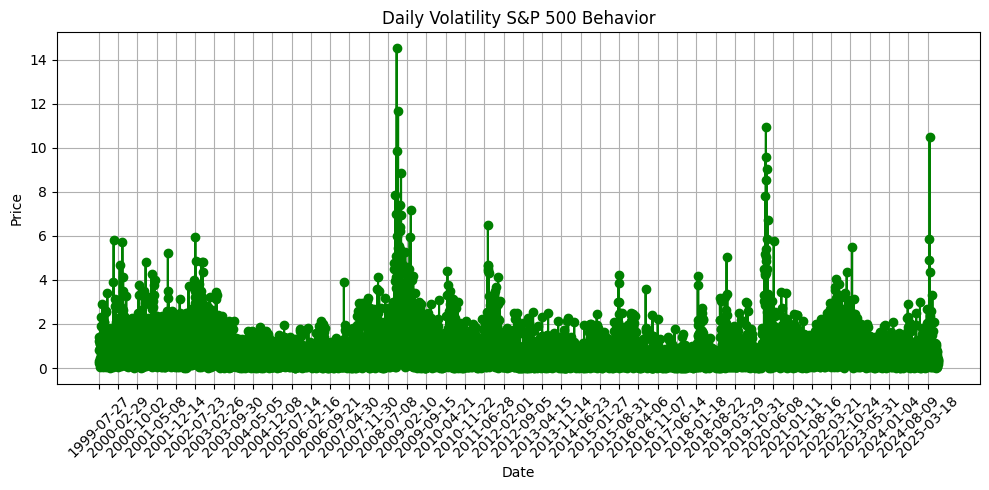

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(SPY_stocks['Date'], SPY_stocks['Daily_Volatility'], marker='o', linestyle='-', color='green')
plt.title('Daily Volatility S&P 500 Behavior')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

skip = 150
plt.xticks(SPY_stocks['Date'][::skip], rotation=45)

plt.tight_layout()
plt.show()

### Apply K means to Segmentation of Volatily

In [16]:
import sys
!{sys.executable} -m pip install scikit-learn

You should consider upgrading via the '/Users/rodrigoesparza/.pyenv/versions/py_7_thesis/bin/python -m pip install --upgrade pip' command.


In [17]:
from sklearn.cluster import KMeans

In [18]:
X = SPY_stocks['Daily_Volatility'].values.reshape(-1, 1)

In [19]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)

In [20]:

centers = sorted(kmeans.cluster_centers_.flatten())

threshold1 = (centers[0] + centers[1]) / 2
threshold2 = (centers[1] + centers[2]) / 2

SPY_stocks['Volatility_Category'] = pd.cut(SPY_stocks['Daily_Volatility'],
                                  bins=[-np.inf, threshold1, threshold2, np.inf],
                                  labels=['Low', 'Medium', 'High'])

In [21]:
SPY_stocks.head()

,Date,Close,Daily_Return,Daily_Volatility,Volatility_Category
1,1999-07-27,85.632195,0.834853,0.834853,Low
2,1999-07-28,85.907906,0.321971,0.321971,Low
3,1999-07-29,84.706596,-1.398369,1.398369,Medium
4,1999-07-30,83.662720,-1.232344,1.232344,Medium
5,1999-08-02,83.859734,0.235486,0.235486,Low


### Visualization of Segmentation

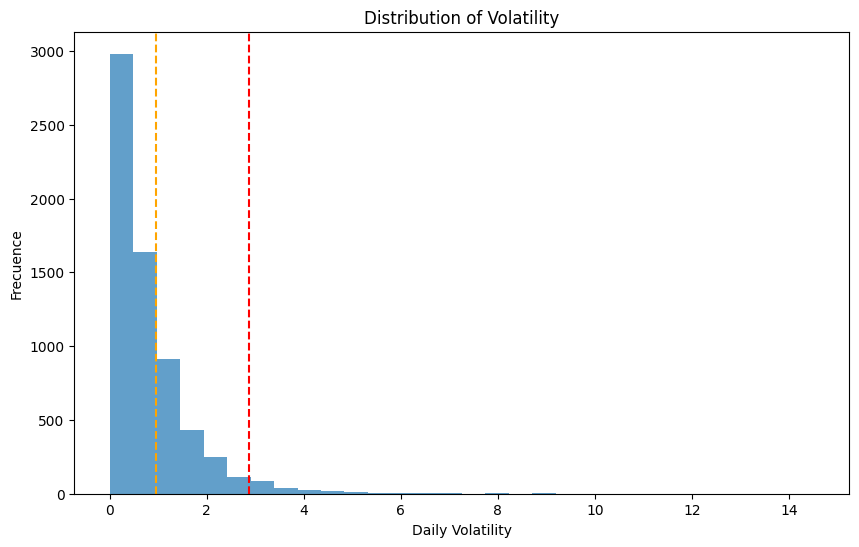

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(SPY_stocks['Daily_Volatility'], bins=30, alpha=0.7)
plt.axvline(threshold1, color='orange', linestyle='--')
plt.axvline(threshold2, color='red', linestyle='--')
plt.title('Distribution of Volatility')
plt.xlabel('Daily Volatility')
plt.ylabel('Frecuence')
plt.show()

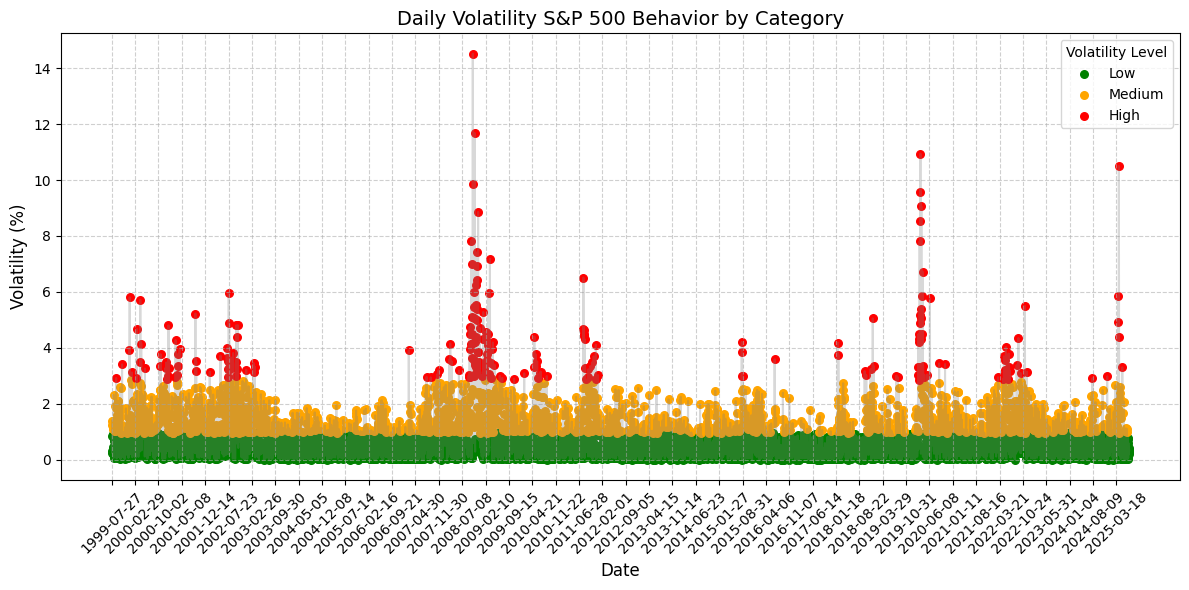

In [23]:
import matplotlib.pyplot as plt
import numpy as np

color_map = {
    'Low': 'green',
    'Medium': 'orange',
    'High': 'red'
}

plt.figure(figsize=(12, 6))

plt.plot(SPY_stocks['Date'], SPY_stocks['Daily_Volatility'], 
         linestyle='-', color='gray', alpha=0.3)

for category, color in color_map.items():
    subset = SPY_stocks[SPY_stocks['Volatility_Category'] == category]
    plt.scatter(subset['Date'], subset['Daily_Volatility'], 
               color=color, label=category, s=30)

plt.title('Daily Volatility S&P 500 Behavior by Category', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

skip = 150
plt.xticks(SPY_stocks['Date'][::skip], rotation=45)

plt.legend(title='Volatility Level')

plt.tight_layout()
plt.show()

### Merge Dataframnes

In [24]:
SPY_stocks['Date'] = pd.to_datetime(SPY_stocks['Date'], format='%Y-%m-%d')

In [25]:
bayes_df = df_news[['date', 'all_text', 'clean_text']]
bayes_df = bayes_df.rename(columns={'date': 'Date'})
bayes_df.head(2)

,Date,all_text,clean_text
0,2000-01-01,"Playoffs or No, Dallas Provides The Motivation Waiting in the visiting locker room at Texas Stadium late tomorrow afternoon, the Giants will know whether the Green Bay Packers, who play earlier against Arizona, have won or are comfortably ahead. Article on upcoming New York Giants-Dallas Cowboys game; photo (M)",playoff dallas provide motivation wait visit locker room texas stadium late tomorrow afternoon giant know green bay packer play early arizona win comfortably ahead article upcoming new york giants dallas cowboys game photo m
1,2000-01-01,"On This First Day, a Fanfare for the New Era; Knowing the World To the Editor: Jeanne C Pond letter expresses hope that spiritual development, artistic knowledge and skills and self-esteem flourish in new century; drawing",day fanfare new era know world editor jeanne c pond letter express hope spiritual development artistic knowledge skill self esteem flourish new century drawing


In [26]:
bayes_df.shape

(2189674, 3)

In [27]:
bayes_df = pd.merge(left=bayes_df, right=SPY_stocks, how='left', on='Date', suffixes=('_left', '_right'))
bayes_df.head(2)

,Date,all_text,clean_text,Close,Daily_Return,Daily_Volatility,Volatility_Category
0,2000-01-01,"Playoffs or No, Dallas Provides The Motivation Waiting in the visiting locker room at Texas Stadium late tomorrow afternoon, the Giants will know whether the Green Bay Packers, who play earlier against Arizona, have won or are comfortably ahead. Article on upcoming New York Giants-Dallas Cowboys game; photo (M)",playoff dallas provide motivation wait visit locker room texas stadium late tomorrow afternoon giant know green bay packer play early arizona win comfortably ahead article upcoming new york giants dallas cowboys game photo m,NaN,NaN,NaN,NaN
1,2000-01-01,"On This First Day, a Fanfare for the New Era; Knowing the World To the Editor: Jeanne C Pond letter expresses hope that spiritual development, artistic knowledge and skills and self-esteem flourish in new century; drawing",day fanfare new era know world editor jeanne c pond letter express hope spiritual development artistic knowledge skill self esteem flourish new century drawing,NaN,NaN,NaN,NaN


In [28]:
bayes_df.shape

(2189674, 7)

In [29]:
#Delet News of Weekends
bayes_df = bayes_df.dropna()
bayes_df.head(2)

,Date,all_text,clean_text,Close,Daily_Return,Daily_Volatility,Volatility_Category
721,2000-01-03,"The Wisdom of Y2K Planning In a welcome anticlimax to two years of dire warnings, the new millennium arrived over the weekend without a computer-driven meltdown of the globe's electronic infrastructure. So far even the countries that did not spend vast sums to prepare for a Y2K-bug disaster have been spared major problems, raising questions about whether all the planning and expense were necessary. The speculation about what might have happened had there been no preparation is intriguing and inevitable. But common sense suggests that inaction was not an option for government and business leaders once the experts determined the existence of a threat to power grids, defense systems, air transport, financial communications and other vital linkages. In a welcome anticlimax to two years of dire warnings, the new millennium arrived over the weekend without a computer-driven meltdown of the globe's electronic infrastructure. So far even the countries that did not spend vast sums to prepare for a Y2K-bug disaster have been spared major problems, raising questions about whether all the planning and expense were necessary. The speculation about what might have happened had there been no preparation is intriguing and inevitable. But common sense suggests that inaction was not an option for government and business leaders once the experts determined the existence of a threat to power grids, defense systems, air transport, financial communications and other vital linkages. Among most computer specialists, the fear of a serious crisis was real. As just about everyone came to learn, their anxiety was that computers would break down because of an inability to recognize the year 2000. A year or so ago, Wired magazine reported that many leading software engineers were themselves planning to spend the New Year's weekend in remote places with stocks of water, cash and food on hand. That fear now seems exaggerated, but it was not entirely fanciful. It reflected the essential fact that even the experts do not fully comprehend the complexity of the systems that now undergird the world's computers. John Koskinen, chairman of the President's Council on Year 2000 Conversion, has warned that it may take weeks or months to be sure that the millennium bug is completely behind us.",wisdom y2k plan welcome anticlimax year dire warning new millennium arrive weekend computer drive meltdown globe s electronic infrastructure far country spend vast sum prepare y2k bug disaster spare major problem raise question planning expense necessary speculation happen preparation intriguing inevitable common sense suggest inaction option government business leader expert determine existence threat power grid defense system air transport financial communication vital linkage welcome anticlimax year dire warning new millennium arrive weekend computer drive meltdown globe s electronic infrastructure far country spend vast sum prepare y2k bug disaster spare major problem raise question planning expense necessary speculation happen preparation intriguing inevitable common sense suggest inaction option government business leader expert determine existence threat power grid defense system air transport financial communication vital linkage computer specialist fear crisis real come learn anxiety computer break inability recognize year 2000 year ago wire magazine report lead software engineer plan spend new year s weekend remote place stock water cash food hand fear exaggerated entirely fanciful reflect essential fact expert fully comprehend complexity system undergird world s computer john koskinen chairman president s council year 2000 conversion warn week month sure millennium bug completely,92.142548,-0.978677,0.978677,Medium
722,2000-01-03,"Robert Parris, Composer, 75, And Professor Of Music Robert Parris, a composer of chamber, orchestral and vocal works and a professor of music, 

In [30]:
bayes_df.shape

(1590610, 7)

In [31]:
bayes_df = bayes_df[['Date', 'all_text', 'clean_text', 'Volatility_Category']]
bayes_df.head(2)

,Date,all_text,clean_text,Volatility_Category
721,2000-01-03,"The Wisdom of Y2K Planning In a welcome anticlimax to two years of dire warnings, the new millennium arrived over the weekend without a computer-driven meltdown of the globe's electronic infrastructure. So far even the countries that did not spend vast sums to prepare for a Y2K-bug disaster have been spared major problems, raising questions about whether all the planning and expense were necessary. The speculation about what might have happened had there been no preparation is intriguing and inevitable. But common sense suggests that inaction was not an option for government and business leaders once the experts determined the existence of a threat to power grids, defense systems, air transport, financial communications and other vital linkages. In a welcome anticlimax to two years of dire warnings, the new millennium arrived over the weekend without a computer-driven meltdown of the globe's electronic infrastructure. So far even the countries that did not spend vast sums to prepare for a Y2K-bug disaster have been spared major problems, raising questions about whether all the planning and expense were necessary. The speculation about what might have happened had there been no preparation is intriguing and inevitable. But common sense suggests that inaction was not an option for government and business leaders once the experts determined the existence of a threat to power grids, defense systems, air transport, financial communications and other vital linkages. Among most computer specialists, the fear of a serious crisis was real. As just about everyone came to learn, their anxiety was that computers would break down because of an inability to recognize the year 2000. A year or so ago, Wired magazine reported that many leading software engineers were themselves planning to spend the New Year's weekend in remote places with stocks of water, cash and food on hand. That fear now seems exaggerated, but it was not entirely fanciful. It reflected the essential fact that even the experts do not fully comprehend the complexity of the systems that now undergird the world's computers. John Koskinen, chairman of the President's Council on Year 2000 Conversion, has warned that it may take weeks or months to be sure that the millennium bug is completely behind us.",wisdom y2k plan welcome anticlimax year dire warning new millennium arrive weekend computer drive meltdown globe s electronic infrastructure far country spend vast sum prepare y2k bug disaster spare major problem raise question planning expense necessary speculation happen preparation intriguing inevitable common sense suggest inaction option government business leader expert determine existence threat power grid defense system air transport financial communication vital linkage welcome anticlimax year dire warning new millennium arrive weekend computer drive meltdown globe s electronic infrastructure far country spend vast sum prepare y2k bug disaster spare major problem raise question planning expense necessary speculation happen preparation intriguing inevitable common sense suggest inaction option government business leader expert determine existence threat power grid defense system air transport financial communication vital linkage computer specialist fear crisis real come learn anxiety computer break inability recognize year 2000 year ago wire magazine report lead software engineer plan spend new year s weekend remote place stock water cash food hand fear exaggerated entirely fanciful reflect essential fact expert fully comprehend complexity system undergird world s computer john koskinen chairman president s council year 2000 conversion warn week month sure millennium bug completely,Medium
722,2000-01-03,"Robert Parris, Composer, 75, And Professor Of Music Robert Parris, a composer of chamber, orchestral and vocal works and a professor of music, died at George Washington University Hospital in Washington on De

### Get 300 most important words

In [32]:
SPY_news = pd.read_csv('../Data/Preprocessed/SPY-news.csv')
SPY_news = SPY_news.drop(['Unnamed: 0'], axis=1)
SPY_news.head(2)

,date,all_text,clean_text,section_name
0,2000-02-17,"Exchange to Offer Derivatives Linked to the Fortune 500 List Move over Dow Jones and Standard & Poor's, here comes the Fortune 500 stock index. Fortune magazine says it is going to allow Chicago Mercantile Exchange to begain offering futures and options linked to new Fortune 500 index, which magazine will create; magazine says it will also license exchange to trade derivatives based on newly developed Fortune E-50 index, which would track performance of companies tied to Internet economy (M)",exchange offer derivative link fortune 500 list dow jones standard poor s come fortune 500 stock index fortune magazine say go allow chicago mercantile exchange begain offer future option link new fortune 500 index magazine create magazine say license exchange trade derivative base newly develop fortune e 50 index track performance company tie internet economy m,Business Day
1,2000-02-26,"STOCKS IN TURMOIL AS WORRIES GROW ON HIGHER RATES The Dow Jones industrial average, which reached a peak of 11,723 last month, closed below the 10,000 mark yesterday for the first time in 10 months as investors dumped shares of companies most vulnerable to higher interest rates. The other popular stock indexes followed suit. Dow Jones industrial average, which reached peak of 11,723 in January, closes below 10,000 for first time in 10 months as investors dump shares of companies most vulnerable to higher interest rates; declines 230.51 points to 9,862.12, down 3.5 percent for week on New York Stock Exchange; other indexes follow suit; Nasdaq falls 27.15 points, to 4,590.50, and Standard & Poor's 500 index 20.07, to 1,333.36; graphs (M)",stock turmoil worry grow high rate dow jones industrial average reach peak 11 723 month close 10 000 mark yesterday time 10 month investor dump share company vulnerable high interest rate popular stock index follow suit dow jones industrial average reach peak 11 723 january close 10 000 time 10 month investor dump share company vulnerable high interest rate decline 230 51 point 9 862 12 3 5 percent week new york stock exchange index follow suit nasdaq fall 27 15 point 4 590 50 standard poor s 500 index 20 07 1 333 36 graph m,Business Day


#### Generate relevant words

In [33]:
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

all_words = []
for text in SPY_news['clean_text']:
    words = word_tokenize(text.lower())
    words = [word for word in words 
              if len(word) >= 3]
    all_words.extend(words)

word_counts = Counter(all_words)
top_300_wordsSets = word_counts.most_common(300)
top_300_wordsSets[:5]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rodrigoesparza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('company', 816),
 ('say', 718),
 ('million', 390),
 ('percent', 380),
 ('year', 379)]

In [34]:
top_300_words = []
for word, cont in top_300_wordsSets:
    top_300_words.append(word)

top_300_words

['company',
 'say',
 'million',
 'percent',
 'year',
 'spy',
 'stock',
 'new',
 'executive',
 'billion',
 'index',
 'krispy',
 'kreme',
 'chief',
 'rise',
 'business',
 'market',
 'report',
 'share',
 '500',
 'fall',
 'sale',
 'hewlett',
 'yesterday',
 'plan',
 'buy',
 'price',
 'packard',
 'computer',
 'federal',
 'security',
 'group',
 'point',
 'pay',
 'quarter',
 'maker',
 'news',
 'investor',
 'deal',
 'profit',
 'high',
 'week',
 'fund',
 'end',
 'standard',
 'board',
 'oil',
 'doughnut',
 'director',
 'poor',
 'sell',
 'united',
 'president',
 'charge',
 'corporation',
 'case',
 'government',
 'agree',
 'month',
 'china',
 'time',
 'investigation',
 'large',
 'service',
 'day',
 'general',
 'base',
 'financial',
 'york',
 'big',
 'close',
 'technology',
 'world',
 'name',
 'leave',
 'bank',
 'states',
 'industrial',
 'offer',
 'dow',
 'chairman',
 'announce',
 'exchange',
 'trade',
 'american',
 'rate',
 'firm',
 'software',
 'increase',
 'earning',
 'page',
 'program',
 'unit',

## Get Relevance Matrix with S&P 500

In [35]:
keywords = ["SP 500", "S P 500""S&P 500", "GSPC", "S&P500", "Standard & Poor's 500", "500 Index", "VOO", "IVV"]
keywords = [keyword.lower() for keyword in keywords]
keywords += top_300_words

vectorizer = TfidfVectorizer(vocabulary=keywords, lowercase=True)
bayes_df['clean_text'] = bayes_df['clean_text'].astype(str)
news_vectors = vectorizer.fit_transform(bayes_df['clean_text'])
#bayes_df['keyword_score'] = news_vectors.sum(axis=1).A1

In [36]:
news_vectors_df = pd.DataFrame(news_vectors.toarray(), columns=vectorizer.get_feature_names_out())
news_vectors_df

,sp 500,s p 500s&p 500,gspc,s&p500,standard & poor's 500,500 index,voo,ivv,company,say,...,reserve,san,disclose,fourth,book,lawyer,silicon,acquisition,head,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.341264,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110775,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214205,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.414409,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1590606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.224650,...,0.0,0.0,0.0,0.0,0.377499,0.0,0.0,0.0,0.0,0.0
1590607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.185170,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1590608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### Get Total Relevance by New

In [37]:
news_vectors_df['Total_Value'] = news_vectors_df.sum(axis=1)
news_vectors_df['Total_Value'] 

0          4.193482
1          1.281232
2          3.165456
3          2.407152
4          1.537046
             ...   
1590605    3.402617
1590606    2.800135
1590607    3.211251
1590608    2.487462
1590609    1.925289
Name: Total_Value, Length: 1590610, dtype: float64

In [38]:
bayes_df.shape

(1590610, 4)

In [39]:
bayes_df = bayes_df.reset_index(drop=True)
news_vectors_df = news_vectors_df.reset_index(drop=True)
bayes_df['SPY_Relevance'] = news_vectors_df['Total_Value']
bayes_df.head(2)

,Date,all_text,clean_text,Volatility_Category,SPY_Relevance
0,2000-01-03,"The Wisdom of Y2K Planning In a welcome anticlimax to two years of dire warnings, the new millennium arrived over the weekend without a computer-driven meltdown of the globe's electronic infrastructure. So far even the countries that did not spend vast sums to prepare for a Y2K-bug disaster have been spared major problems, raising questions about whether all the planning and expense were necessary. The speculation about what might have happened had there been no preparation is intriguing and inevitable. But common sense suggests that inaction was not an option for government and business leaders once the experts determined the existence of a threat to power grids, defense systems, air transport, financial communications and other vital linkages. In a welcome anticlimax to two years of dire warnings, the new millennium arrived over the weekend without a computer-driven meltdown of the globe's electronic infrastructure. So far even the countries that did not spend vast sums to prepare for a Y2K-bug disaster have been spared major problems, raising questions about whether all the planning and expense were necessary. The speculation about what might have happened had there been no preparation is intriguing and inevitable. But common sense suggests that inaction was not an option for government and business leaders once the experts determined the existence of a threat to power grids, defense systems, air transport, financial communications and other vital linkages. Among most computer specialists, the fear of a serious crisis was real. As just about everyone came to learn, their anxiety was that computers would break down because of an inability to recognize the year 2000. A year or so ago, Wired magazine reported that many leading software engineers were themselves planning to spend the New Year's weekend in remote places with stocks of water, cash and food on hand. That fear now seems exaggerated, but it was not entirely fanciful. It reflected the essential fact that even the experts do not fully comprehend the complexity of the systems that now undergird the world's computers. John Koskinen, chairman of the President's Council on Year 2000 Conversion, has warned that it may take weeks or months to be sure that the millennium bug is completely behind us.",wisdom y2k plan welcome anticlimax year dire warning new millennium arrive weekend computer drive meltdown globe s electronic infrastructure far country spend vast sum prepare y2k bug disaster spare major problem raise question planning expense necessary speculation happen preparation intriguing inevitable common sense suggest inaction option government business leader expert determine existence threat power grid defense system air transport financial communication vital linkage welcome anticlimax year dire warning new millennium arrive weekend computer drive meltdown globe s electronic infrastructure far country spend vast sum prepare y2k bug disaster spare major problem raise question planning expense necessary speculation happen preparation intriguing inevitable common sense suggest inaction option government business leader expert determine existence threat power grid defense system air transport financial communication vital linkage computer specialist fear crisis real come learn anxiety computer break inability recognize year 2000 year ago wire magazine report lead software engineer plan spend new year s weekend remote place stock water cash food hand fear exaggerated entirely fanciful reflect essential fact expert fully comprehend complexity system undergird world s computer john koskinen chairman president s council year 2000 conversion warn week month sure millennium bug completely,Medium,4.193482
1,2000-01-03,"Robert Parris, Composer, 75, And Professor Of Music Robert Parris, a composer of chamber, orchestral and vocal works and a professor of music, died at George Washington University Hospital 

In [40]:
bayes_df.isnull().sum()

Date                   0
all_text               0
clean_text             0
Volatility_Category    0
SPY_Relevance          0
dtype: int64

### Normalize Relevance (0 - 10)

In [80]:
print(bayes_df['SPY_Relevance'].min())
print(bayes_df['SPY_Relevance'].max())
print(bayes_df['SPY_Relevance'].mean())

0.0
10.375846527550433
2.3984637607967505


In [81]:
bayes_df['SPY_Relevance'] = (bayes_df['SPY_Relevance'] - bayes_df['SPY_Relevance'].min()) / (bayes_df['SPY_Relevance'].max() - bayes_df['SPY_Relevance'].min()) * 10

In [82]:
print(bayes_df['SPY_Relevance'].min())
print(bayes_df['SPY_Relevance'].max())
print(bayes_df['SPY_Relevance'].mean())

0.0
10.0
2.3115836904759903


In [41]:
bayes_df[bayes_df['SPY_Relevance'] < 1 ].head(2)

,Date,all_text,clean_text,Volatility_Category,SPY_Relevance
114,2000-01-03,"Ideal Preschools To the Editor: To the Editor: Re ''Another Model for Schools'' (column, Dec. 28), by Anthony Lewis:",ideal preschool editor editor model school column dec 28 anthony lewis,Medium,0.0
277,2000-01-04,"2000: How Are We Doing So Far? To the Editor: To the Editor: William Safire (column, Jan. 1) asks, ''Why Die?''",2000 far editor editor william safire column jan 1 ask die,High,0.0


In [42]:
bayes_df[bayes_df['SPY_Relevance'] > 8 ].head(2)

Date  \
11645 2000-03-13   
15566 2000-04-04   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [85]:
bins = range(0, 11)
bayes_df['Range'] = pd.cut(bayes_df['SPY_Relevance'], bins=bins, right=False)
count_by_range = bayes_df['Range'].value_counts().sort_index()
print(count_by_range)

[0, 1)     119726
[1, 2)     416248
[2, 3)     756140
[3, 4)     264647
[4, 5)      28708
[5, 6)       3203
[6, 7)        800
[7, 8)        551
[8, 9)        526
[9, 10)        60
Name: Range, dtype: int64


In [86]:
print(bayes_df.Date.min())
print(bayes_df.Date.max())
print(bayes_df.shape)

2000-01-03 00:00:00
2024-12-13 00:00:00
(1590610, 7)


In [87]:
bayes_df.to_csv('../Data/Preprocessed/News_Volatility_Relevance.csv')

In [53]:
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=np.inf)
print(bayes_df.Date.unique())

['2000-01-03T00:00:00.000000000' '2000-01-04T00:00:00.000000000'
 '2000-01-05T00:00:00.000000000' '2000-01-06T00:00:00.000000000'
 '2000-01-07T00:00:00.000000000' '2000-01-10T00:00:00.000000000'
 '2000-01-11T00:00:00.000000000' '2000-01-12T00:00:00.000000000'
 '2000-01-13T00:00:00.000000000' '2000-01-14T00:00:00.000000000'
 '2000-01-18T00:00:00.000000000' '2000-01-19T00:00:00.000000000'
 '2000-01-20T00:00:00.000000000' '2000-01-21T00:00:00.000000000'
 '2000-01-24T00:00:00.000000000' '2000-01-25T00:00:00.000000000'
 '2000-01-26T00:00:00.000000000' '2000-01-27T00:00:00.000000000'
 '2000-01-28T00:00:00.000000000' '2000-01-31T00:00:00.000000000'
 '2000-02-01T00:00:00.000000000' '2000-02-02T00:00:00.000000000'
 '2000-02-03T00:00:00.000000000' '2000-02-04T00:00:00.000000000'
 '2000-02-07T00:00:00.000000000' '2000-02-08T00:00:00.000000000'
 '2000-02-09T00:00:00.000000000' '2000-02-10T00:00:00.000000000'
 '2000-02-11T00:00:00.000000000' '2000-02-14T00:00:00.000000000'
 '2000-02-15T00:00:00.000

### Get Sentiment of new

In [54]:
def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)['compound']

In [55]:
bayes_df['Sentiment'] = bayes_df['all_text'].apply(get_sentiment)
bayes_df.head(3)

,Date,all_text,clean_text,Volatility_Category,SPY_Relevance,Range,Sentiment
721,2000-01-03,"The Wisdom of Y2K Planning In a welcome anticlimax to two years of dire warnings, the new millennium arrived over the weekend without a computer-driven meltdown of the globe's electronic infrastructure. So far even the countries that did not spend vast sums to prepare for a Y2K-bug disaster have been spared major problems, raising questions about whether all the planning and expense were necessary. The speculation about what might have happened had there been no preparation is intriguing and inevitable. But common sense suggests that inaction was not an option for government and business leaders once the experts determined the existence of a threat to power grids, defense systems, air transport, financial communications and other vital linkages. In a welcome anticlimax to two years of dire warnings, the new millennium arrived over the weekend without a computer-driven meltdown of the globe's electronic infrastructure. So far even the countries that did not spend vast sums to prepare for a Y2K-bug disaster have been spared major problems, raising questions about whether all the planning and expense were necessary. The speculation about what might have happened had there been no preparation is intriguing and inevitable. But common sense suggests that inaction was not an option for government and business leaders once the experts determined the existence of a threat to power grids, defense systems, air transport, financial communications and other vital linkages. Among most computer specialists, the fear of a serious crisis was real. As just about everyone came to learn, their anxiety was that computers would break down because of an inability to recognize the year 2000. A year or so ago, Wired magazine reported that many leading software engineers were themselves planning to spend the New Year's weekend in remote places with stocks of water, cash and food on hand. That fear now seems exaggerated, but it was not entirely fanciful. It reflected the essential fact that even the experts do not fully comprehend the complexity of the systems that now undergird the world's computers. John Koskinen, chairman of the President's Council on Year 2000 Conversion, has warned that it may take weeks or months to be sure that the millennium bug is completely behind us.",wisdom y2k plan welcome anticlimax year dire warning new millennium arrive weekend computer drive meltdown globe s electronic infrastructure far country spend vast sum prepare y2k bug disaster spare major problem raise question planning expense necessary speculation happen preparation intriguing inevitable common sense suggest inaction option government business leader expert determine existence threat power grid defense system air transport financial communication vital linkage welcome anticlimax year dire warning new millennium arrive weekend computer drive meltdown globe s electronic infrastructure far country spend vast sum prepare y2k bug disaster spare major problem raise question planning expense necessary speculation happen preparation intriguing inevitable common sense suggest inaction option government business leader expert determine existence threat power grid defense system air transport financial communication vital linkage computer specialist fear crisis real come learn anxiety computer break inability recognize year 2000 year ago wire magazine report lead software engineer plan spend new year s weekend remote place stock water cash food hand fear exaggerated entirely fanciful reflect essential fact expert fully comprehend complexity system undergird world s computer john koskinen chairman president s council year 2000 conversion warn week month sure millennium bug completely,Medium,3.465107,"[3, 4)",-0.9900
722,2000-01-03,"Robert Parris, Composer, 75, And Professor Of Music Robert Parris, a composer of chamber, orchestral and vocal works and a professor of music, died at G

In [48]:
all_news_df = pd.read_csv('../Data/Preprocessed/New_SPY_Stocks-sentiments.csv')
all_news_df.head(1)

,Unnamed: 0,Date,all_text,clean_text,Volatility_Category,SPY_Relevance,Range,Sentiment
0,0,2000-01-03,"The Wisdom of Y2K Planning In a welcome anticlimax to two years of dire warnings, the new millennium arrived over the weekend without a computer-driven meltdown of the globe's electronic infrastructure. So far even the countries that did not spend vast sums to prepare for a Y2K-bug disaster have been spared major problems, raising questions about whether all the planning and expense were necessary. The speculation about what might have happened had there been no preparation is intriguing and inevitable. But common sense suggests that inaction was not an option for government and business leaders once the experts determined the existence of a threat to power grids, defense systems, air transport, financial communications and other vital linkages. In a welcome anticlimax to two years of dire warnings, the new millennium arrived over the weekend without a computer-driven meltdown of the globe's electronic infrastructure. So far even the countries that did not spend vast sums to prepare for a Y2K-bug disaster have been spared major problems, raising questions about whether all the planning and expense were necessary. The speculation about what might have happened had there been no preparation is intriguing and inevitable. But common sense suggests that inaction was not an option for government and business leaders once the experts determined the existence of a threat to power grids, defense systems, air transport, financial communications and other vital linkages. Among most computer specialists, the fear of a serious crisis was real. As just about everyone came to learn, their anxiety was that computers would break down because of an inability to recognize the year 2000. A year or so ago, Wired magazine reported that many leading software engineers were themselves planning to spend the New Year's weekend in remote places with stocks of water, cash and food on hand. That fear now seems exaggerated, but it was not entirely fanciful. It reflected the essential fact that even the experts do not fully comprehend the complexity of the systems that now undergird the world's computers. John Koskinen, chairman of the President's Council on Year 2000 Conversion, has warned that it may take weeks or months to be sure that the millennium bug is completely behind us.",wisdom y2k plan welcome anticlimax year dire warning new millennium arrive weekend computer drive meltdown globe s electronic infrastructure far country spend vast sum prepare y2k bug disaster spare major problem raise question planning expense necessary speculation happen preparation intriguing inevitable common sense suggest inaction option government business leader expert determine existence threat power grid defense system air transport financial communication vital linkage welcome anticlimax year dire warning new millennium arrive weekend computer drive meltdown globe s electronic infrastructure far country spend vast sum prepare y2k bug disaster spare major problem raise question planning expense necessary speculation happen preparation intriguing inevitable common sense suggest inaction option government business leader expert determine existence threat power grid defense system air transport financial communication vital linkage computer specialist fear crisis real come learn anxiety computer break inability recognize year 2000 year ago wire magazine report lead software engineer plan spend new year s weekend remote place stock water cash food hand fear exaggerated entirely fanciful reflect essential fact expert fully comprehend complexity system undergird world s computer john koskinen chairman president s council year 2000 conversion warn week month sure millennium bug completely,Medium,4.04158,"[4, 5)",-0.99


In [51]:
bayes_df = bayes_df.reset_index(drop=True)
all_news_df = all_news_df.reset_index(drop=True)

bayes_df['Sentiment'] = all_news_df['Sentiment']

In [96]:
bayes_df.isnull().sum()

Date                   0
all_text               0
clean_text             0
Volatility_Category    0
SPY_Relevance          0
Range                  1
Sentiment              0
dtype: int64

In [97]:
bayes_df.to_csv('../Data/Preprocessed/New_SPY_Stocks-sentiments.csv')

### News Analysis Results

In [50]:
all_news_df = all_news_df.drop(['Unnamed: 0', 'clean_text', 'Range'], axis=1)
all_news_df.head(1)

,Date,all_text,Volatility_Category,SPY_Relevance,Sentiment
0,2000-01-03,"The Wisdom of Y2K Planning In a welcome anticlimax to two years of dire warnings, the new millennium arrived over the weekend without a computer-driven meltdown of the globe's electronic infrastructure. So far even the countries that did not spend vast sums to prepare for a Y2K-bug disaster have been spared major problems, raising questions about whether all the planning and expense were necessary. The speculation about what might have happened had there been no preparation is intriguing and inevitable. But common sense suggests that inaction was not an option for government and business leaders once the experts determined the existence of a threat to power grids, defense systems, air transport, financial communications and other vital linkages. In a welcome anticlimax to two years of dire warnings, the new millennium arrived over the weekend without a computer-driven meltdown of the globe's electronic infrastructure. So far even the countries that did not spend vast sums to prepare for a Y2K-bug disaster have been spared major problems, raising questions about whether all the planning and expense were necessary. The speculation about what might have happened had there been no preparation is intriguing and inevitable. But common sense suggests that inaction was not an option for government and business leaders once the experts determined the existence of a threat to power grids, defense systems, air transport, financial communications and other vital linkages. Among most computer specialists, the fear of a serious crisis was real. As just about everyone came to learn, their anxiety was that computers would break down because of an inability to recognize the year 2000. A year or so ago, Wired magazine reported that many leading software engineers were themselves planning to spend the New Year's weekend in remote places with stocks of water, cash and food on hand. That fear now seems exaggerated, but it was not entirely fanciful. It reflected the essential fact that even the experts do not fully comprehend the complexity of the systems that now undergird the world's computers. John Koskinen, chairman of the President's Council on Year 2000 Conversion, has warned that it may take weeks or months to be sure that the millennium bug is completely behind us.",Medium,4.04158,-0.99


### Get Average of Relevance and Sentiment by day and add to stock DF

In [98]:
news_avrg_df = bayes_df.copy()
news_avrg_df = news_avrg_df.groupby('Date')[['SPY_Relevance', 'Sentiment']].mean().reset_index()
news_avrg_df.head()

,Date,SPY_Relevance,Sentiment
0,2000-01-03,2.454406,0.263196
1,2000-01-04,2.578125,0.262992
2,2000-01-05,2.689423,0.273089
3,2000-01-06,2.641906,0.256221
4,2000-01-07,2.609040,0.225330


In [99]:
SPY_stocks.head(2)

,Date,Close,Daily_Return,Daily_Volatility,Volatility_Category
1,1999-07-27,85.632195,0.834853,0.834853,Low
2,1999-07-28,85.907906,0.321971,0.321971,Low


In [100]:
SPY_stocks['Date'] = pd.to_datetime(SPY_stocks['Date'])
news_avrg_df['Date'] = pd.to_datetime(news_avrg_df['Date'])

new_spy_stocks = pd.merge(left=SPY_stocks, right=news_avrg_df, how='left', on='Date', suffixes=('_left', '_right'))
new_spy_stocks.head()

,Date,Close,Daily_Return,Daily_Volatility,Volatility_Category,SPY_Relevance,Sentiment
0,1999-07-27,85.632195,0.834853,0.834853,Low,NaN,NaN
1,1999-07-28,85.907906,0.321971,0.321971,Low,NaN,NaN
2,1999-07-29,84.706596,-1.398369,1.398369,Medium,NaN,NaN
3,1999-07-30,83.662720,-1.232344,1.232344,Medium,NaN,NaN
4,1999-08-02,83.859734,0.235486,0.235486,Low,NaN,NaN


In [101]:
new_spy_stocks.iloc[300]

Date                   2000-10-02 00:00:00
Close                            91.809662
Daily_Return                      0.152397
Daily_Volatility                  0.152397
Volatility_Category                    Low
SPY_Relevance                     2.345339
Sentiment                         0.210621
Name: 300, dtype: object

In [102]:
new_spy_stocks.to_csv('../Data/Preprocessed/New_SPY_Stocks-news.csv')

### Native Bayes to predict Volatility

In [52]:
bayes_df = bayes_df[['clean_text', 'Volatility_Category']]
bayes_df.head(3)

,clean_text,Volatility_Category
0,wisdom y2k plan welcome anticlimax year dire warning new millennium arrive weekend computer drive meltdown globe s electronic infrastructure far country spend vast sum prepare y2k bug disaster spare major problem raise question planning expense necessary speculation happen preparation intriguing inevitable common sense suggest inaction option government business leader expert determine existence threat power grid defense system air transport financial communication vital linkage welcome anticlimax year dire warning new millennium arrive weekend computer drive meltdown globe s electronic infrastructure far country spend vast sum prepare y2k bug disaster spare major problem raise question planning expense necessary speculation happen preparation intriguing inevitable common sense suggest inaction option government business leader expert determine existence threat power grid defense system air transport financial communication vital linkage computer specialist fear crisis real come learn anxiety computer break inability recognize year 2000 year ago wire magazine report lead software engineer plan spend new year s weekend remote place stock water cash food hand fear exaggerated entirely fanciful reflect essential fact expert fully comprehend complexity system undergird world s computer john koskinen chairman president s council year 2000 conversion warn week month sure millennium bug completely,Medium
1,robert parris composer 75 professor music robert parris composer chamber orchestral vocal work professor music die george washington university hospital washington dec 5 75 live chevy chase md robert parris composer chamber orchestral vocal work professor music die george washington university hospital washington dec 5 75 live chevy chase md cause lung cancer say steven r gerber composer study mr parris,Medium
2,people gail c day name publisher playboy magazine new york executive vice president playboy publishing group playboy enterprises inc succeed richard kinsler vice president publisher popular science magazine new york time mirror magazine unit time mirror company ms day publisher sport illustrate kid new york time inc unit time warner inc gail c day name publisher playboy magazine new york executive vice president playboy publishing group playboy enterprises inc succeed richard kinsler vice president publisher popular science magazine new york time mirror magazine unit time mirror company ms day publisher sport illustrate kid new york time inc unit time warner inc,Medium


In [ ]:
tv = TfidfVectorizer(stop_words='english', ngram_range=(2,4))
Xt = tv.fit_transform(bayes_df['clean_text'])
Xt_df = pd.DataFrame(Xt.toarray(), columns=tv.get_feature_names_out())
Xt_df

In [ ]:
y = bayes_df['Volatility_Category']
y.head()

In [ ]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(Xt_df, y, test_size=0.2, random_state=42)

# model
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

# predict
y_pred_nb = model_nb.predict(X_test)

# evaluate
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))